# Product Matching
## Level 5: Model Evaluation Script

### Notes:
1. Evaluate the Support Vector Machine model on train and test data

### References: 

## Notebook Config

In [1]:
# Display settings
## Auto reload modules & inline plots
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Package Import & Initialization

In [2]:
# Import packages

import pandas as pd                  #For data manipulation and bgq --> pandas conversion
import numpy as np                   #For scientific computation
import os                            #For work with native operating system and directories
from pathlib import Path             #For working with file paths and directories
import warnings                      #To tweak warning options
import datetime as dt                #For date objects and implemetations
from sklearn.base import BaseEstimator               #For creating a simple baseline model
from sklearn.pipeline import Pipeline       #For linking various data ETL moves together
from sklearn.preprocessing import StandardScaler, PolynomialFeatures  #For standardizing/tranforming numeric variables 
from sklearn.model_selection import cross_val_score, cross_val_predict  #For performing model cross-validation
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,\
    recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score  #For evaluating classifier model
# from sklearn import tree             #For visualizing decision trees
from graphviz import Source               #For storing decision tree visualizations
import joblib                        #For saving objects, more efficient at serializing large numpy arrays than pickle module
import matplotlib.pyplot as plt      #Standard plotting package

In [3]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format
warnings.filterwarnings('ignore')

## Function Library

In [33]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):    
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")    
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")  
    plt.legend(loc='center right', fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    # plt.axis([-50000, 50000, 0, 1])

In [5]:
# def plot_precision_vs_recall(precisions, recalls):
#     plt.plot(recalls, precisions, "b-", linewidth=2)
#     plt.xlabel("Recall", fontsize=16)
#     plt.ylabel("Precision", fontsize=16)
#     plt.axis([0, 1, 0, 1])
#     plt.grid(True)

In [6]:
# def plot_roc_curve(fpr, tpr, label=None):
#     plt.plot(fpr, tpr, linewidth=2, label=label)
#     plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
#     plt.axis([0, 1, 0, 1])                                   
#     plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
#     plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
#     plt.grid(True)                                            

## Custom Tranformers

## Set Directories

In [7]:
#cwd = os.getcwd()
#os.chdir(cwd)
home = str(Path.home())
proj_path = os.path.join(home, 'Cardinal Health', 'Enterprise Data Remediation - Documents', 'General', '01_Projects', 
                         '23_Kinaxis')

In [8]:
main_dir = proj_path + '\\'
iput_dir = main_dir + 'Data\\Output\\ML\\'
oput_dir = main_dir + 'Data\\Output\\ML\\'

## Set Output File Names

## Load Model

In [9]:
mdl_obj = joblib.load(iput_dir + "L403_mdl_2022-08-03.pkl")

## Load Data

In [10]:
## Training Data
X = joblib.load(iput_dir + "L300_prd_df_2022-07-15.pkl")
y = joblib.load(iput_dir + "L300_tgt_df_2022-07-15.pkl")

In [11]:
## Test Data
tst_df = (
    pd
    .read_pickle(iput_dir + "L100_tst_df_2022-07-15.pkl")
    .rename(columns = dict(zip(
        ['Feat_1','Feat_2','Feat_3','Feat_4','Feat_5','Feat_6'],
        ['Feat_Exact_SuppItemNum','Feat_Fuzzy_SuppName','Feat_Fuzzy_ItemDesc','Feat_Exact_ItemNum','Feat_Exact_UNSPSC','Feat_Fuzzy_SuppItemNum']
    )))
)

X_tst = StandardScaler().fit_transform(tst_df.filter(regex='^Feat', axis="columns").values)  ##Need to use standard scaler from feature creation
y_tst = tst_df.assign(Match = lambda df: np.where(df.Match=='Yes', 1, 0)).Match

In [12]:
tst_df.Match.value_counts()

No     261
Yes    156
Name: Match, dtype: int64

In [13]:
## Standard Scaler Transformer
X_Scaler = joblib.load(iput_dir + "L300_sclr_obj_2022-07-15.pkl")

In [14]:
## Standard Scaler Transformations
X_scld     = X_Scaler.transform(X)
X_tst_scld = X_Scaler.transform(X_tst)

## Baseline Model Creation

In [15]:
class NotMatchClassifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.zeros(len(X), dtype=bool)
    
not_match_clf = NotMatchClassifier()

## Visualize Model

## Evaluate Model

#### Primary error metric (Accuracy)

In [16]:
## Training
print(sum(not_match_clf.predict(X_scld)==y)/len(y))
print(sum(mdl_obj.predict(X_scld)==y)/len(y))

0.6085131894484412
0.9976019184652278


In [17]:
##Training
print(accuracy_score(not_match_clf.predict(X_scld), y))
print(accuracy_score(mdl_obj.predict(X_scld), y))

0.6085131894484412
0.9976019184652278


In [18]:
##Testing
print(sum(not_match_clf.predict(X_tst_scld)==y_tst)/len(y_tst))
print(sum(mdl_obj.predict(X_tst_scld)==y_tst)/len(y_tst))

0.6258992805755396
0.9040767386091128


In [19]:
##Testing
print(accuracy_score(not_match_clf.predict(X_tst_scld), y_tst))
print(accuracy_score(mdl_obj.predict(X_tst_scld), y_tst))

0.6258992805755396
0.9040767386091128


#### Cross-validation

In [20]:
print(cross_val_score(not_match_clf, X_scld, y, cv=5, scoring="accuracy"))
print(cross_val_score(mdl_obj, X_scld, y, cv=5, scoring="accuracy"))

[0.54491018 0.63473054 0.63173653 0.5975976  0.63363363]
[0.99401198 0.99700599 0.99700599 0.996997   1.        ]


#### Confusion Matrix - Precision - Recall

In [21]:
y_trn_pred = cross_val_predict(mdl_obj, X_scld, y, cv=5)
y_tst_pred = mdl_obj.predict(X_tst_scld)

Training

In [22]:
## Actual (row) vs. Predicted (column) - negative first, positive second
## [[true neg, false pos],[false neg, true pos]]
confusion_matrix(y, y_trn_pred)

array([[1012,    3],
       [   2,  651]], dtype=int64)

In [23]:
precision_score(y, y_trn_pred)

0.9954128440366973

In [24]:
recall_score(y, y_trn_pred)

0.996937212863706

In [25]:
f1_score(y, y_trn_pred)

0.9961744452945678

Testing

In [26]:
## Actual (row) vs. Predicted (column) - negative first, positive second
## [[true neg, false pos],[false neg, true pos]]
confusion_matrix(y_tst, y_tst_pred)

array([[261,   0],
       [ 40, 116]], dtype=int64)

In [27]:
precision_score(y_tst, y_tst_pred)

1.0

In [28]:
recall_score(y_tst, y_tst_pred)

0.7435897435897436

In [29]:
f1_score(y_tst, y_tst_pred)

0.8529411764705882

#### Plots

In [35]:
y_scores = cross_val_predict(mdl_obj, X_scld, y, cv=5, method="predict_proba")
precisions, recalls, thresholds = precision_recall_curve(y, y_scores[:,1])

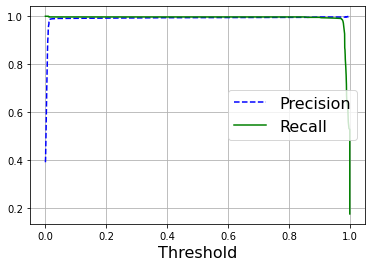

In [36]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

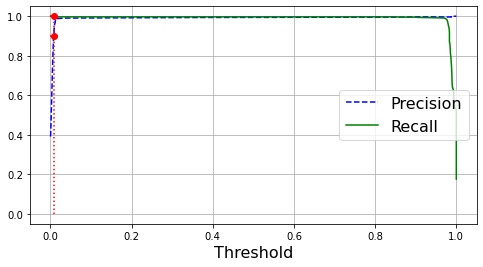

In [37]:
tgt_precision = 0.9

recall_90_precision = recalls[np.argmax(precisions >= tgt_precision)]
threshold_90_precision = thresholds[np.argmax(precisions >= tgt_precision)]

plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., max(tgt_precision,recall_90_precision)], "r:")                 
plt.plot([min(thresholds), threshold_90_precision], [tgt_precision, tgt_precision], "r:")                                
plt.plot([min(thresholds), threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [tgt_precision], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                                             
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., tgt_precision], "r:")
plt.plot([0.0, recall_90_precision], [tgt_precision, tgt_precision], "r:")
plt.plot([recall_90_precision], [tgt_precision], "ro")
plt.show()

In [ ]:
threshold_90_precision

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [ ]:
precision_score(y, y_train_pred_90)

In [ ]:
recall_score(y, y_train_pred_90)

In [ ]:
f1_score(y, y_train_pred_90)

In [ ]:
fpr, tpr, thresholds = roc_curve(y, y_scores)

In [ ]:
plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")                                    
plt.show()

In [ ]:
roc_auc_score(y, y_scores)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X, y, cv=3,
                                    method="predict_proba")

In [ ]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y,y_scores_forest)

In [ ]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [ ]:
roc_auc_score(y, y_scores_forest)

In [ ]:
y_train_pred_forest = cross_val_predict(forest_clf, X, y, cv=3)
precision_score(y, y_train_pred_forest)